### IRIS 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋: iris.csv 2개 (1개 피쳐, 1개 타겟) feature 사용
- Linear regression
- 너비 예측
- 구현_프레임워크: Pytorch
- Train, test, Validation Dataset 생성

In [1]:
import torch					# 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn			# 인공신경망 관련 모듈
import torch.nn.functional as F 	# 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈

import pandas as pd				# 데이터 파일 분석 관련 모듈

from sklearn.model_selection import train_test_split		# trainDS, testDS 분할 관련 모듈듈

In [2]:
torch.manual_seed(1)

In [3]:
DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[2,3])			# 컬럼 2개만 사용
irisDF.head(2)

,petal.length,petal.width
0,1.4,0.2
1,1.4,0.2


[2] 모델 준비
- 학습방법: 지도학습 >> 회귀
- 알고리즘: 선형관계 >> 선형모델 >> nn.Linear

In [17]:
# in_features	: petal.length 1개
# out_features	: petal.width  1개

model = nn.Linear(1,1)

# 멀티 layer 예시)
nn_model = nn.Sequential( nn.Linear(3, 10),
                         nn.ReLU(),
              nn.Linear(10,50),
         nn.ReLU(),
      nn.Linear(50,1) )

In [5]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
	print(f'[{name}] {param}', end='\n\n')

[weight] Parameter containing:
tensor([[0.5153]], requires_grad=True)

[bias] Parameter containing:
tensor([-0.4414], requires_grad=True)



[3] 최적화 인스턴스 준비
- 모델의 가중치 & 절편 최적화
- 최적화 결과 인스턴스에 전달 		=> optimizer.step()

In [6]:
adam_optim = optimizer.Adam(model.parameters(), lr = 0.1)		# model.parameter() -> weight, bias

''' 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)
'''

' \nAdam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    lr: 0.1\n    maximize: False\n    weight_decay: 0\n)\n'

[4] 학습
- 개발자가 구현 
- 알아서 잘~~~~~~~~~~~~ 8ㅅ8

- [4-1] 데이터셋 Tensor화 진행
	* 데이터 준비 시 or 학습 전

In [7]:
irisDF[['petal.length']][:10]

,petal.length
0,1.4
1,1.4
2,1.3
3,1.5
4,1.4
5,1.7
6,1.4
7,1.5
8,1.4
9,1.5


In [8]:
irisDF[['petal.length']][:10].values

array([[1.4],
       [1.4],
       [1.3],
       [1.5],
       [1.4],
       [1.7],
       [1.4],
       [1.5],
       [1.4],
       [1.5]])

In [9]:
featureTS = torch.from_numpy( irisDF[['petal.length']].values ).float()			# 2D
featureTS.shape

torch.Size([150, 1])

In [10]:
targetTS = torch.from_numpy( irisDF[['petal.width']].values).float()				# 2D
targetTS.shape

torch.Size([150, 1])

In [11]:
# Train & test 분할
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS,
                                                    test_size = 0.2, random_state=10)

# Train & Valid 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=10)

print(f'[Feature] Train {X_train.shape}, TEST {X_test.shape}, Valid {X_val.shape}')
print(f'[Target]  Train {y_train.shape}, TEST {y_test.shape}, Valid {y_val.shape}')

[Feature] Train torch.Size([96, 1]), TEST torch.Size([30, 1]), Valid torch.Size([24, 1])
[Target]  Train torch.Size([96, 1]), TEST torch.Size([30, 1]), Valid torch.Size([24, 1])


- [4-2] 학습진행
	* 학습횟수 결정		=> epoch 설정
	* 학습결과 저장		=> 손실 저장 변수

##### 테스트/검증 함수
	- => 가중치, 절편 업데이트 X, 최적화 미진행
	- 현재 가중치 & 절편값으로 테스트 진행

In [12]:
# 학습한 모델 검증(Validation) 목적 함수
def testing(testTS, targetTS, kind='Validation'):
	vali_history = []				# epoch 횟수에 따른 loss 시각화 목적 저장 리스트!!

	with torch.no_grad():			# 가중치 업데이트 없이 
		# (1) 학습진행 - forward			
		pre_y = model(testTS)
	
		# (2) 오차계산 - 손실함수
		loss = F.mse_loss(pre_y, targetTS)
															# numpy 값만 저장하기 위해 loss.item()
	
		# (3) 학습결과 출력&저장 
		print(f'[{kind} LOSS: {loss} ')

	return loss

In [13]:
EPOCH = 10


# 모델 학습 함수	
#		 	  학습용
def training(featureTS, targetTS, valTS, valTargetTS):

	loss_history = [ [], [] ]							# epoch 횟수에 따른 loss 시각화 용!! [ [Train], [Val] ]
	# loss_history = {}									# epoch 횟수에 따른 loss 시각화 용!!

	# 모델 학습 EPOCH 만큼
	for epoch in range(EPOCH):
		# (1) 학습진행 - forward			
		pre_y = model(featureTS)
	
		# (2) 오차계산 - 손실함수
		loss = F.mse_loss(pre_y, targetTS)
		loss_history[0].append(loss.item())							# loss는 텐서!! 
		# loss_history['Train'].append(loss.item())					# loss는 텐서!! 
															# numpy 값만 저장하기 위해 loss.item()
		# (3) 최적화   - 가중치, 절편 업데이트 - backward, step
		# 			=> 업데이트 안하면 모든 epoch에 대해 가중치,절편 똑같은 값!
		adam_optim.zero_grad()
		loss.backward()
		adam_optim.step()

		# (4) 모델 검증
		val_loss = testing(valTS, valTargetTS)
		loss_history[1].append(val_loss.item())					# loss는 텐서!! 
		# loss_history['Val'] = val_loss.item()
	
		# (5) 학습결과 출력&저장 
		print(f'[{epoch}/{EPOCH}] LOSS: {loss} ')

	return loss_history

In [14]:
loss_per_epoch = training(X_train, y_train, X_val, y_val)
# loss_per_epoch

[Validation LOSS: 0.07163837552070618 
[0/10] LOSS: 0.16223937273025513 
[Validation LOSS: 0.12169066816568375 
[1/10] LOSS: 0.08536016941070557 
[Validation LOSS: 0.06638569384813309 
[2/10] LOSS: 0.141363725066185 
[Validation LOSS: 0.04511846601963043 
[3/10] LOSS: 0.07933203130960464 
[Validation LOSS: 0.07858201861381531 
[4/10] LOSS: 0.051974862813949585 
[Validation LOSS: 0.09107919782400131 
[5/10] LOSS: 0.0840003713965416 
[Validation LOSS: 0.06590410321950912 
[6/10] LOSS: 0.09626241773366928 
[Validation LOSS: 0.04374464228749275 
[7/10] LOSS: 0.0707496777176857 
[Validation LOSS: 0.04833154380321503 
[8/10] LOSS: 0.04986852779984474 
[Validation LOSS: 0.0619841106235981 
[9/10] LOSS: 0.0576363168656826 


In [15]:
type(loss_per_epoch)

list

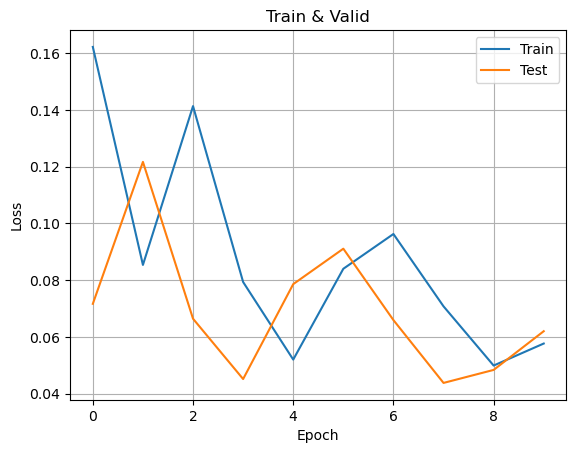

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_per_epoch[0])), loss_per_epoch[0], label='Train')
plt.plot(range(len(loss_per_epoch[1])), loss_per_epoch[1], label='Test')
plt.grid()

plt.title('Train & Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()